In [ ]:
"""

Last change on Tue Aug 25 2024

Calculation of the XCO/XCO2 ratio based on abundance differences

@author: lgrosch@iup.physik.uni-bremen.de

"""

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

# To be changed before running the code:
    - path to data by setting date and station number
    - adjusting bias compensation factor
    - adjusting number of scans

In [2]:
# Read in data

emission_data1 = pd.read_csv("C:/Users/admin/Desktop/Bremen/Semester_4_24/Masterarbeit/ratios/comb_invparms_Stahlwerk_hb_1_SN082_240514-240514.csv", sep="\t",)
emission_data2 = pd.read_csv("C:/Users/admin/Desktop/Bremen/Semester_4_24/Masterarbeit/ratios/comb_invparms_Stahlwerk_hb_2_SN082_240514-240514.csv", sep="\t",)
emission_data5 = pd.read_csv("C:/Users/admin/Desktop/Bremen/Semester_4_24/Masterarbeit/ratios/comb_invparms_Stahlwerk_hb_5_SN082_240719-240719.csv", sep="\t",)        
emission_data8 = pd.read_csv("C:/Users/admin/Desktop/Bremen/Semester_4_24/Masterarbeit/ratios/comb_invparms_Stahlwerk_hb_8_SN082_240731-240731.csv", sep="\t",)
emission_data9 = pd.read_csv("C:/Users/admin/Desktop/Bremen/Semester_4_24/Masterarbeit/ratios/comb_invparms_Stahlwerk_hb_9_SN082_240731-240731.csv", sep="\t",)

# Store number of scans

emission_data1['scans'] = 10
emission_data2['scans'] = 10
emission_data5['scans'] = 6
#emission_data8['scans'] = 6
#emission_data9['scans'] = 4

# Combined emission data according to bcf

emission_data12 = pd.concat([emission_data1, emission_data2], ignore_index=True)
#emission_data589 = pd.concat([emission_data5, emission_data8, emission_data9], ignore_index=True)

In [3]:
# Define BCFs and calculate calibrated values

BCF_XCO2 = 0.998801
BCF_XCO589 = 1.011283      #average
BCF_XCO12 = 0.994524       #for 14th May (station 1 and 2)


emission_data12['XCO2_calibr'] = emission_data12['XCO2'] / BCF_XCO2
emission_data12['XCO_calibr'] = emission_data12['XCO'] / BCF_XCO12
emission_data5['XCO2_calibr'] = emission_data5['XCO2'] / BCF_XCO2
emission_data5['XCO_calibr'] = emission_data5['XCO'] / BCF_XCO589
#emission_data89['XCO2_calibr'] = emission_data589['XCO2'] / BCF_XCO2
#emission_data89['XCO_calibr'] = emission_data589['XCO'] / BCF_XCO589

# Combined emission data for all stations

emission_data = pd.concat([emission_data12, emission_data5], ignore_index=True)
#emission_data = pd.concat([emission_data12, emission_data589], ignore_index=True)

In [4]:
# Calculate the differences between consecutive values in XCO2 and XCO

emission_data['diff_XCO2'] = emission_data['XCO2_calibr'].diff()
emission_data['diff_XCO'] = emission_data['XCO_calibr'].diff()

In [5]:
# Calculate the ratio diff_XCO / diff_XCO2

emission_data['CO/CO2_ratio [%]'] = (emission_data['diff_XCO'] / emission_data['diff_XCO2']) *100

In [9]:
# Define the ranges of level_XCO and level_XCO2 to iterate over
level_XCO_values = np.arange(0.0, 0.029, 0.001)  # 0.001 to 0.03 in steps of 0.001
level_XCO2_values = np.arange(0.0, 1.05, 0.05)       # 0.1 to 1.6 in steps of 0.1

# Create a list to store the results
results = []

In [14]:
# Loop through each combination of level_XCO and level_XCO2
for level_XCO in level_XCO_values:
    for level_XCO2 in level_XCO2_values:
        # Apply the conditions and add a new column 'used'
        emission_data['used'] = (emission_data['diff_XCO2'] * emission_data['diff_XCO'] > 0) & \
                                (emission_data['diff_XCO2'].abs() > (level_XCO2 * (emission_data['scans']/10))) & \
                                (emission_data['diff_XCO'].abs() > (level_XCO * (emission_data['scans']/10))) & \
                                (emission_data['XCO2'] != 0) & \
                                (emission_data['XCO'] != 0)

        # Filter the data where 'used' is True
        used_data = emission_data[emission_data['used']]
        
        # Calculate the average, standard deviation, and count of the used ratios
        avg_ratio = used_data['CO/CO2_ratio [%]'].mean()
        std_ratio = used_data['CO/CO2_ratio [%]'].std()
        count_ratio = used_data['CO/CO2_ratio [%]'].count()

        # Store the results
        results.append({
            'level_XCO': level_XCO,
            'level_XCO2': level_XCO2,
            'avg_ratio': avg_ratio,
            'std_ratio': std_ratio,
            'count_ratio': count_ratio
        })


In [15]:
print(used_data['CO/CO2_ratio [%]'])

8       1.399877
29      1.883493
32      6.281452
37      1.567178
38      1.070952
46     10.733617
84      1.538398
113     8.844044
115     4.086002
122     3.347864
155     1.745517
161     1.816983
162     2.020742
239     3.617945
Name: CO/CO2_ratio [%], dtype: float64


In [18]:
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

#Define optimal values for the properties
std_ratio_opt = 0.3 # Example optimal value for property 1 (lower is better)
count_ratio_opt = 15  # Example optimal value for property 2 (higher is better)

# Normalize the properties relative to optimal values
def normalize_std_ratio(std_ratio, std_ratio_opt):
    return 1 - (abs(std_ratio - std_ratio_opt) / std_ratio_opt)

def normalize_count_ratio(count_ratio, count_ratio_opt):
    return (count_ratio - min(count_ratio)) / (count_ratio_opt - min(count_ratio))

# Apply normalization
results_df['normalized_std_ratio'] = normalize_std_ratio(results_df['std_ratio'], std_ratio_opt)
results_df['normalized_count_ratio'] = normalize_count_ratio(results_df['count_ratio'], count_ratio_opt)

# Define weights for combining properties
w1 = 0.7
w2 = 0.3

# Calculate the quality metric
results_df['quality_metric'] = w1 * results_df['normalized_std_ratio'] + w2 * results_df['normalized_count_ratio']

In [19]:
# Compute min and max values for each property
#std_ratio_min = results_df['std_ratio'].min()
#std_ratio_max = results_df['std_ratio'].max()
#count_ratio_min = results_df['count_ratio'].min()
#count_ratio_max = results_df['count_ratio'].max()

std_ratio_min = 0
std_ratio_max = 1
count_ratio_min = 0
count_ratio_max = 60

print(f"std_ratio_min: {std_ratio_min}")
print(f"std_ratio_max: {std_ratio_max}")
print(f"count_ratio_min: {count_ratio_min}")
print(f"count_ratio_max: {count_ratio_max}")

std_ratio_min: 0
std_ratio_max: 1
count_ratio_min: 0
count_ratio_max: 60


In [31]:
# Normalize the properties
def normalize_std_ratio(std_ratio, std_ratio_min, std_ratio_max):
    return (std_ratio_max - std_ratio) / (std_ratio_max - std_ratio_min)

def normalize_count_ratio(count_ratio, count_ratio_min, count_ratio_max):
    return (count_ratio - count_ratio_min) / (count_ratio_max - count_ratio_min)

# Apply normalization
results_df['normalized_std_ratio'] = normalize_std_ratio(results_df['std_ratio'], std_ratio_min, std_ratio_max)
results_df['normalized_count_ratio'] = normalize_count_ratio(results_df['count_ratio'], count_ratio_min, count_ratio_max)

# Define weights for combining properties
w1 = 0.55
w2 = 0.45

# Calculate the quality metric
results_df['quality_metric'] = w1 * results_df['normalized_std_ratio'] + w2 * results_df['normalized_count_ratio'] 

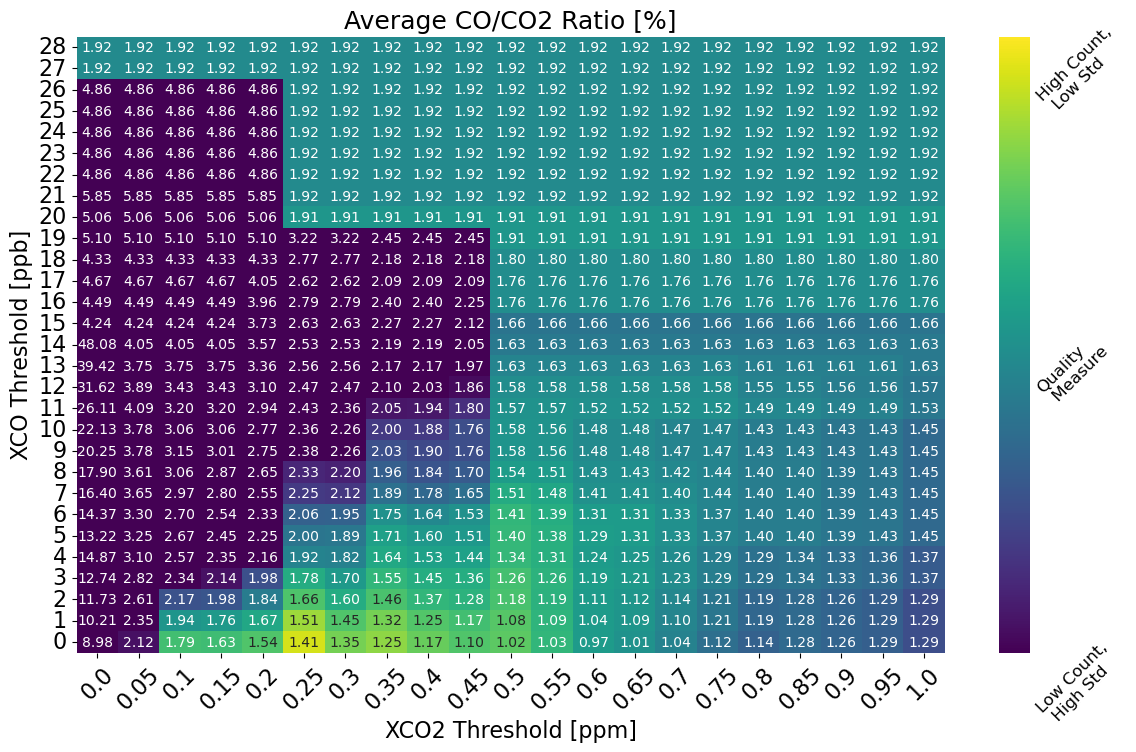

In [35]:
# Create a pivot table for the heatmap with swapped axes
pivot_good = results_df.pivot("level_XCO", "level_XCO2", "quality_metric")
pivot_avg = results_df.pivot("level_XCO", "level_XCO2", "avg_ratio")

# Define color limits
vmin = pivot_good.min().min()
vmax = pivot_good.max().max()

# Plot the heatmap
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(
    pivot_good, 
    cmap="viridis", 
    annot=pivot_avg, 
    fmt=".2f", 
    annot_kws={"size": 10},  # Adjust the font size here
    vmin=0.2, 
    vmax=0.8,
)

# Invert the y-axis
heatmap.invert_yaxis()

# Customize axis labels
plt.title('Average CO/CO2 Ratio [%]', fontsize=18)
plt.xlabel('XCO2 Threshold [ppm]', fontsize=16)
plt.ylabel('XCO Threshold [ppb]', fontsize=16)

# Get current y-axis tick positions and set custom integer labels
yticks = heatmap.get_yticks()
yticklabels = [str(int(tick-0.5)) for tick in yticks]
heatmap.set_yticklabels(yticklabels, rotation=0)

xticks = heatmap.get_xticks()
xticklabels = [str(int(tick)/20) for tick in xticks]
heatmap.set_xticklabels(xticklabels, rotation=45)

# Change font size of the tick values
plt.xticks(fontsize=16)  # Change the font size for x-axis ticks
plt.yticks(fontsize=16)

# Customize the colorbar
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([0.2, 0.5, 0.8])
colorbar.set_ticklabels(['Low Count,\n High Std', 'Quality\n Measure', 'High Count,\n Low Std'])
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.tick_params(size=0)
for label in colorbar.ax.get_yticklabels():
    label.set_rotation(45)  # Set rotation angle here

# Save the plot to a file
#output_file = 'weighted_ratio_threshold_dependence.png'
#plt.savefig(output_file, bbox_inches='tight', dpi=300)  # Adjust dpi for quality

# Show the plot
plt.show()

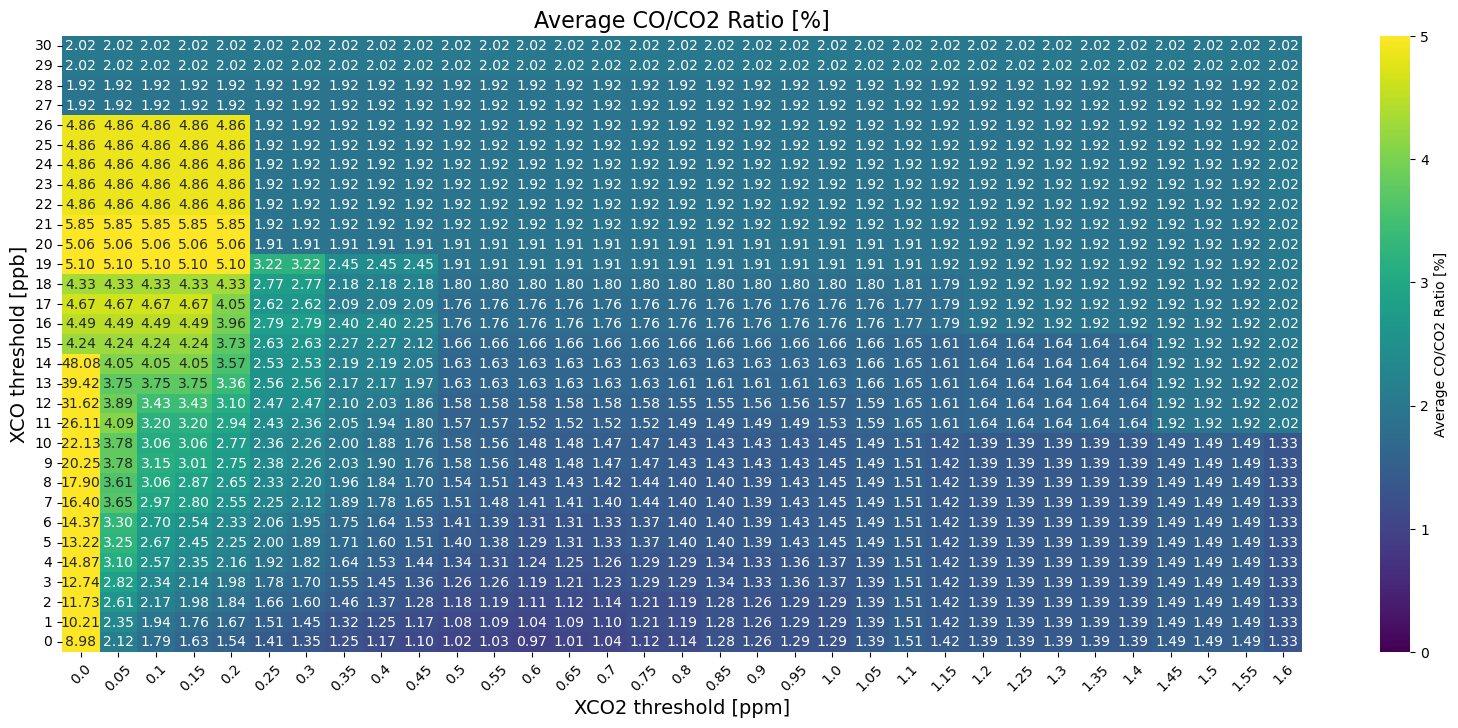

In [13]:
# Create a pivot table for the heatmap with swapped axes
pivot_table = results_df.pivot("level_XCO", "level_XCO2", "avg_ratio")

# Define color limits
vmin = pivot_table.min().min()
vmax = pivot_table.max().max()

# Plot the heatmap
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(
    pivot_table, 
    cmap="viridis", 
    cbar_kws={'label': 'Average CO/CO2 Ratio [%]'}, 
    annot=True, 
    fmt=".2f", 
    annot_kws={"size": 10},  # Adjust the font size here
    vmin=0, 
    vmax=5,
)

# Invert the y-axis
heatmap.invert_yaxis()

# Customize axis labels
plt.title('Average CO/CO2 Ratio [%]', fontsize=16)
plt.xlabel('XCO2 threshold [ppm]', fontsize=14)
plt.ylabel('XCO threshold [ppb]', fontsize=14)

# Get current y-axis tick positions and set custom integer labels
yticks = heatmap.get_yticks()
yticklabels = [str(int(tick-0.5)) for tick in yticks]
heatmap.set_yticklabels(yticklabels, rotation=0)

xticks = heatmap.get_xticks()
xticklabels = [str(int(tick)/20) for tick in xticks]
heatmap.set_xticklabels(xticklabels, rotation=45)

# Save the plot to a file
#output_file = 'avg_threshold_dependence.png'
#plt.savefig(output_file, bbox_inches='tight', dpi=300)  # Adjust dpi for quality

# Show the plot
plt.show()

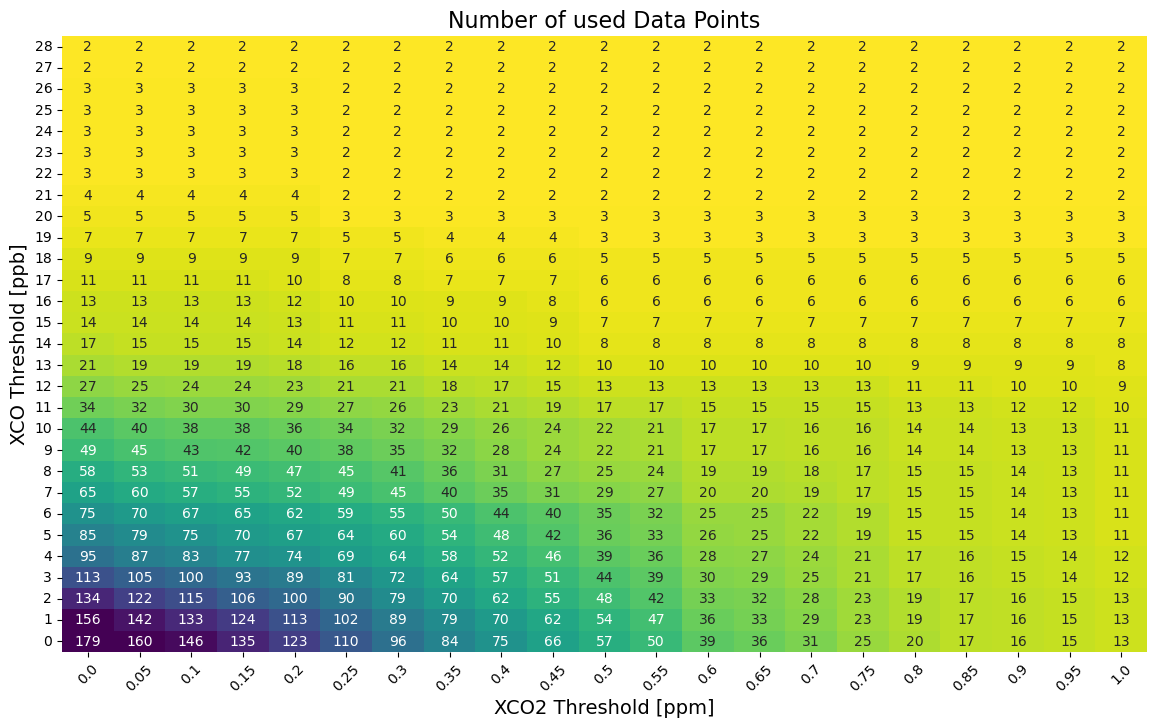

In [26]:
# Create a pivot table for the heatmap with swapped axes
pivot_table = results_df.pivot("level_XCO", "level_XCO2", "count_ratio")

# Define color limits
vmin = pivot_table.min().min()
vmax = pivot_table.max().max()

# Plot the heatmap
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(
    pivot_table, 
    cmap="viridis_r", 
    cbar_kws={'label': 'Number of used Data Points'}, 
    annot=True, 
    fmt=".0f", 
    annot_kws={"size": 10},  # Adjust the font size here
    vmin=vmin, 
    vmax=150,
    cbar=False 
)

# Invert the y-axis
heatmap.invert_yaxis()

# Customize axis labels
plt.title('Number of used Data Points', fontsize=16)
plt.xlabel('XCO2 Threshold [ppm]', fontsize=14)
plt.ylabel('XCO Threshold [ppb]', fontsize=14)

# Get current y-axis tick positions and set custom integer labels
yticks = heatmap.get_yticks()
yticklabels = [str(int(tick-0.5)) for tick in yticks]
heatmap.set_yticklabels(yticklabels, rotation=0)

xticks = heatmap.get_xticks()
xticklabels = [str(int(tick)/20) for tick in xticks]
heatmap.set_xticklabels(xticklabels, rotation=45)

# Save the plot to a file
output_file = 'count_threshold_dependence.png'
plt.savefig(output_file, bbox_inches='tight', dpi=300)  # Adjust dpi for quality

# Show the plot
plt.show()

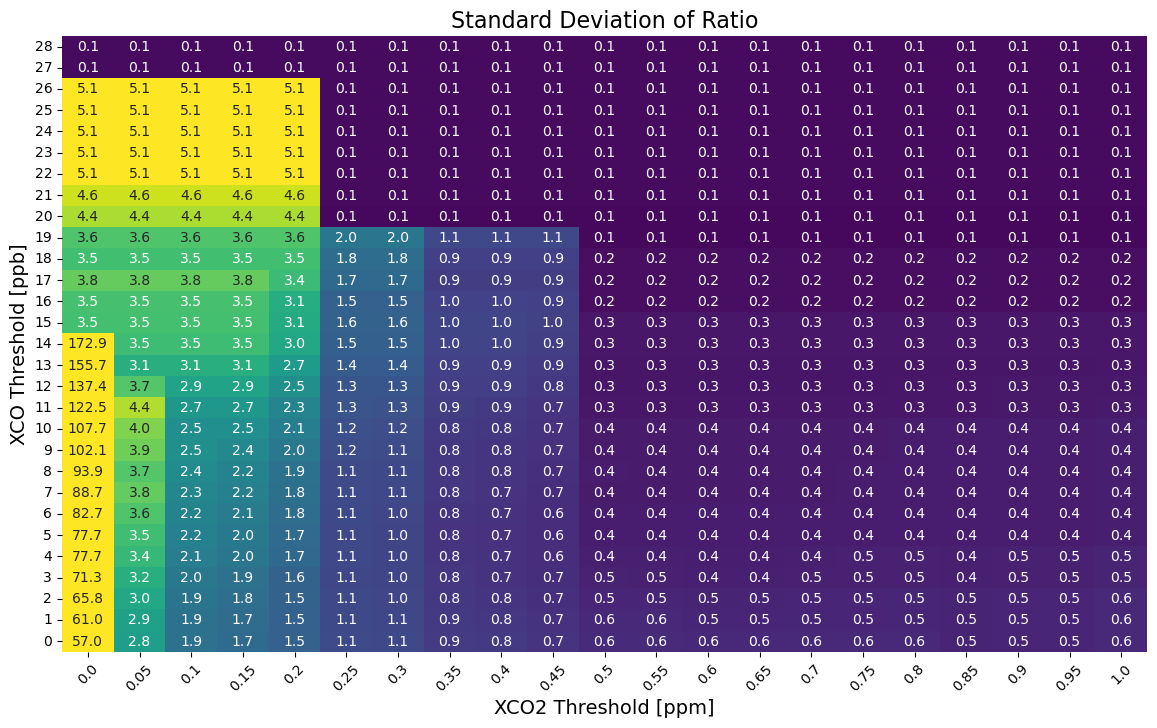

In [28]:
# Create a pivot table for the heatmap with swapped axes
pivot_table = results_df.pivot("level_XCO", "level_XCO2", "std_ratio")

# Define color limits
vmin = pivot_table.min().min()
vmax = pivot_table.max().max()

# Plot the heatmap
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(
    pivot_table, 
    cmap="viridis", 
    cbar_kws={'label': 'Standard Deviation of Ratio'}, 
    annot=True, 
    fmt=".1f", 
    annot_kws={"size": 10},  # Adjust the font size here
    vmin=0, 
    vmax=5,
    cbar=False 
)

# Invert the y-axis
heatmap.invert_yaxis()

# Customize axis labels
plt.title('Standard Deviation of Ratio', fontsize=16)
plt.xlabel('XCO2 Threshold [ppm]', fontsize=14)
plt.ylabel('XCO Threshold [ppb]', fontsize=14)

# Get current y-axis tick positions and set custom integer labels
yticks = heatmap.get_yticks()
yticklabels = [str(int(tick-0.5)) for tick in yticks]
heatmap.set_yticklabels(yticklabels, rotation=0)

xticks = heatmap.get_xticks()
xticklabels = [str(int(tick)/20) for tick in xticks]
heatmap.set_xticklabels(xticklabels, rotation=45)

# Save the plot to a file
output_file = 'std_threshold_dependence.png'
plt.savefig(output_file, bbox_inches='tight', dpi=300)  # Adjust dpi for quality

# Show the plot
plt.show()

In [25]:
#print(emission_data[["XCO2", "XCO", "diff_XCO2", "diff_XCO", "used"]].head(40))

In [27]:
# Display the result

#print(f"Average ratio: {round(avg_ratio,3)} %")
#print(f"Standard deviation of ratio: {round(std_ratio, 3)} %")
#print(f"Count of highlighted ratios: {count_ratio}")

Average ratio: 1.583 %
Standard deviation of ratio: 0.37 %
Count of highlighted ratios: 22


In [65]:
results_df.to_csv('ratio_threshold_dependence.csv', sep=';', decimal=',', index=False)